In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2

In [2]:
df_sales = pd.read_csv('Sales Transaction v.4a.csv') # membaca file

# Data Cleansing

In [3]:
# 1. Ubah kolom Date menjadi tipe datetime
df_sales['Date']= pd.to_datetime(df_sales['Date'])

# 2. Buang semua transaksi yang memiliki quantity negative atau yang TransactionNo diawali dengan C
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']
df_sales

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536320,536585,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,2,17460.0,United Kingdom
536321,536590,2018-12-01,22776,Sweetheart 3 Tier Cake Stand,20.45,1,13065.0,United Kingdom
536322,536590,2018-12-01,22622,Box Of Vintage Alphabet Blocks,20.45,2,13065.0,United Kingdom
536323,536591,2018-12-01,37449,Ceramic Cake Stand + Hanging Cakes,20.45,1,14606.0,United Kingdom


# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di July ?
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

# Segmentasi Produk

## Tabel Volume dan Total Revenue

In [4]:
# Menghitung Volume Transaksi
volume_transaksi = df_sales.groupby("ProductNo")["TransactionNo"].nunique().reset_index()
volume_transaksi.columns = ["ProductNo", "Volume"]

# Menghitung Total Revenue (Price * Quantity)
df_sales["Revenue"] = df_sales["Price"] * df_sales["Quantity"]
total_revenue = df_sales.groupby("ProductNo")["Revenue"].sum().reset_index()
total_revenue.columns = ["ProductNo", "Total_Revenue"]

# Menggabungkan kedua metrik
df_segmented = volume_transaksi.merge(total_revenue, on="ProductNo")

# Mengambil nama produk dari df_sales
product_names = df_sales[["ProductNo", "ProductName"]].drop_duplicates()

# Menggabungkan ProductName ke df_segmented
df_segmented = df_segmented.merge(product_names, on="ProductNo", how="left")

# Menentukan batas segmentasi (20% teratas, 20-80%, dan 20% terbawah)
quantile_volume = df_segmented["Volume"].quantile([0.2, 0.8])
quantile_revenue = df_segmented["Total_Revenue"].quantile([0.2, 0.8])

# Menentukan kategori Volume
def categorize_volume(volume):
    if volume >= quantile_volume[0.8]:
        return "Popular"
    elif volume >= quantile_volume[0.2]:
        return "Normal"
    else:
        return "Low"

df_segmented["Volume_Category"] = df_segmented["Volume"].apply(categorize_volume)

# Menentukan kategori Revenue
def categorize_revenue(revenue):
    if revenue >= quantile_revenue[0.8]:
        return "Popular"
    elif revenue >= quantile_revenue[0.2]:
        return "Normal"
    else:
        return "Low"

df_segmented["Revenue_Category"] = df_segmented["Total_Revenue"].apply(categorize_revenue)

# Menentukan kategori final berdasarkan kombinasi Volume dan Revenue
def categorize_final(row):
    if row["Volume_Category"] == "Popular" and row["Revenue_Category"] == "Popular":
        return "Super Popular"
    elif row["Volume_Category"] == "Popular" or row["Revenue_Category"] == "Popular":
        return "Popular"
    elif row["Volume_Category"] == "Low" and row["Revenue_Category"] == "Low":
        return "Low"
    else:
        return "Normal"

df_segmented["Final_Category"] = df_segmented.apply(categorize_final, axis=1)

# Menampilkan beberapa baris pertama hasil segmentasi
df_segmented


,ProductNo,Volume,Total_Revenue,ProductName,Volume_Category,Revenue_Category,Final_Category
0,10002,71,9592.81,Inflatable Political Globe,Normal,Normal,Normal
1,10080,22,3227.89,Groovy Cactus Inflatable,Normal,Normal,Normal
2,10120,29,1977.77,Doggy Rubber,Normal,Normal,Normal
3,10123C,3,54.60,Hearts Wrapping Tape,Low,Low,Low
4,10124A,5,170.88,Spots On Red Bookcover Tape,Low,Low,Low
...,...,...,...,...,...,...,...
3748,90214U,1,73.56,"Letter ""U"" Bling Key Ring",Low,Low,Low
3749,90214V,14,229.86,"Letter ""V"" Bling Key Ring",Normal,Low,Normal
3750,90214W,5,117.98,"Letter ""W"" Bling Key Ring",Low,Low,Low
3751,90214Y,8,437.75,"Letter ""Y"" Bling Key Ring",Low,Low,Low


# Visualisasi Segmentasi Low, Normal, Popular, Super Popular

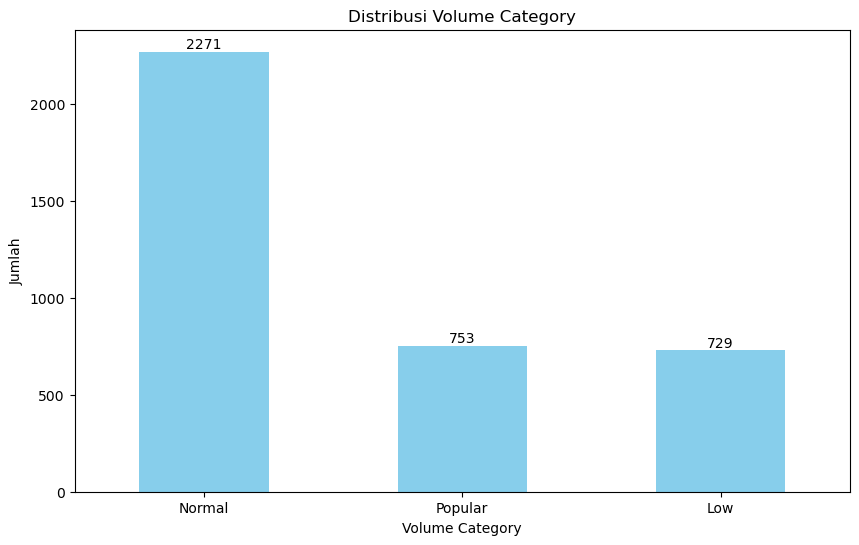

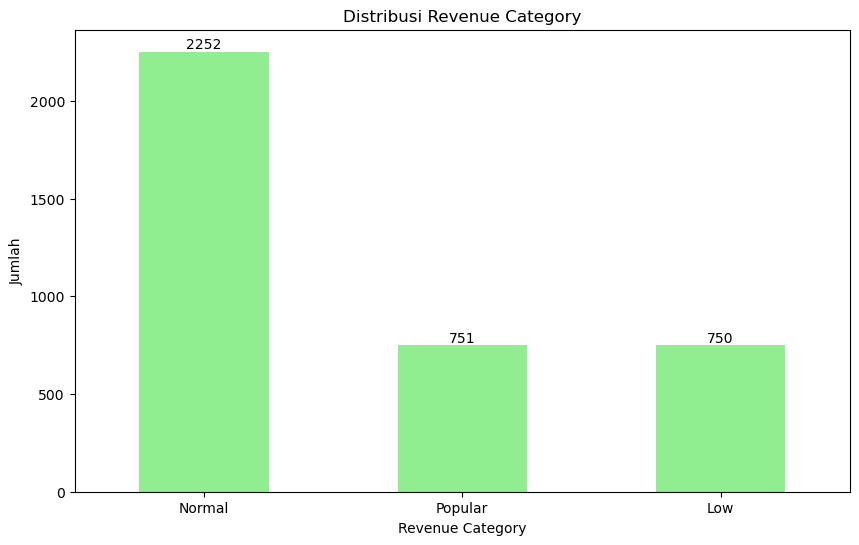

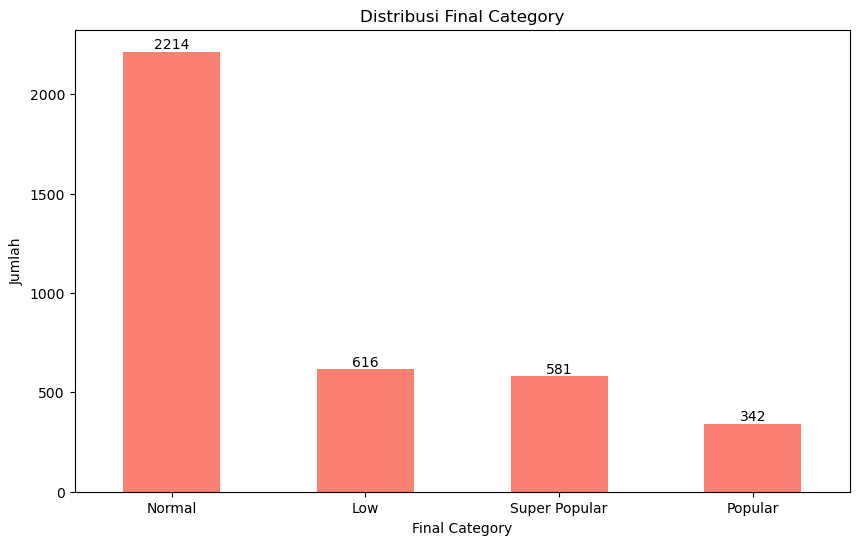

In [5]:
# Visualisasi chart bar untuk Volume Category
plt.figure(figsize=(10,6))
df_segmented['Volume_Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribusi Volume Category')
plt.xlabel('Volume Category')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
for i, value in enumerate(df_segmented['Volume_Category'].value_counts()):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

# Visualisasi chart bar untuk Revenue Category
plt.figure(figsize=(10,6))
df_segmented['Revenue_Category'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribusi Revenue Category')
plt.xlabel('Revenue Category')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
for i, value in enumerate(df_segmented['Revenue_Category'].value_counts()):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

# Visualisasi chart bar untuk Final Category
plt.figure(figsize=(10,6))
df_segmented['Final_Category'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribusi Final Category')
plt.xlabel('Final Category')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
for i, value in enumerate(df_segmented['Final_Category'].value_counts()):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

# Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?

In [6]:
# Filter data untuk November 2019
df_nov = df_sales[(df_sales["Date"].dt.year == 2019) & (df_sales["Date"].dt.month == 11)].copy() # memfilter data mencegah warning

# Persiapan Pertanyaan ke 2
# Filter data untuk July 2019
df_july = df_sales[(df_sales["Date"].dt.year == 2019) & (df_sales["Date"].dt.month == 7)].copy() # memfilter data mencegah warning
df_nov

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Revenue
25361,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432.0,United Kingdom,48.32
25362,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432.0,United Kingdom,24.16
25363,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432.0,United Kingdom,48.32
25364,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432.0,United Kingdom,60.40
25365,579522,2019-11-30,23240,Set Of 4 Knick Knack Tins Doily,6.19,6,14432.0,United Kingdom,37.14
...,...,...,...,...,...,...,...,...,...
109370,573909,2019-11-01,22501,Picnic Basket Wicker Large,20.45,3,17813.0,United Kingdom,61.35
109371,573909,2019-11-01,23471,Six Drawer Office Tidy,20.45,1,17813.0,United Kingdom,20.45
109372,573913,2019-11-01,22635,Childs Breakfast Set Dolly Girl,20.45,2,17653.0,United Kingdom,40.90
109373,573914,2019-11-01,22120,Welcome Wooden Block Letters,20.45,3,14383.0,United Kingdom,61.35


In [7]:
# Re-define the segment_products function
def segment_products(df):
    # Calculate Transaction Volume
    volume_transaksi = df.groupby("ProductNo")["TransactionNo"].nunique().reset_index()
    volume_transaksi.columns = ["ProductNo", "Volume"]

    # Calculate Total Revenue
    df["Revenue"] = df["Price"] * df["Quantity"]
    total_revenue = df.groupby("ProductNo")["Revenue"].sum().reset_index()
    total_revenue.columns = ["ProductNo", "Total_Revenue"]

    # Merge volume and revenue data
    df_segmented = volume_transaksi.merge(total_revenue, on="ProductNo")

    # Set segmentation quantiles
    quantile_volume = df_segmented["Volume"].quantile([0.2, 0.8])
    quantile_revenue = df_segmented["Total_Revenue"].quantile([0.2, 0.8])

    # Categorize Volume
    df_segmented["Volume_Category"] = df_segmented["Volume"].apply(
        lambda x: "Popular" if x >= quantile_volume[0.8] else "Low" if x < quantile_volume[0.2] else "Normal"
    )

    # Categorize Revenue
    df_segmented["Revenue_Category"] = df_segmented["Total_Revenue"].apply(
        lambda x: "Popular" if x >= quantile_revenue[0.8] else "Low" if x < quantile_revenue[0.2] else "Normal"
    )

    # Categorize Final
    df_segmented["Final_Category"] = df_segmented.apply(
        lambda row: "Super Popular" if row["Volume_Category"] == "Popular" and row["Revenue_Category"] == "Popular"
        else "Popular" if row["Volume_Category"] == "Popular" or row["Revenue_Category"] == "Popular"
        else "Low" if row["Volume_Category"] == "Low" and row["Revenue_Category"] == "Low"
        else "Normal", axis=1
    )

    return df_segmented

# Segmenting products for November and July
df_nov_segmented = segment_products(df_nov)
df_july_segmented = segment_products(df_july)

# Getting Super Popular items for November 2019
super_popular_nov = df_nov_segmented[df_nov_segmented["Final_Category"] == "Super Popular"]

# Adding ProductName to super_popular_nov and sorting by Total_Revenue
product_names = df_sales[["ProductNo", "ProductName"]].drop_duplicates()

# Merging ProductName into the super_popular_nov dataframe
super_popular_nov = super_popular_nov.merge(product_names, on="ProductNo", how="left")

# Sorting by Total_Revenue in descending order
super_popular_nov_sorted = super_popular_nov.sort_values(by="Total_Revenue", ascending=False)

# Display the sorted result
super_popular_nov_sorted


,ProductNo,Volume,Total_Revenue,Volume_Category,Revenue_Category,Final_Category,ProductName
253,23084,487,159889.96,Popular,Popular,Super Popular,Rabbit Night Light
117,22197,244,123424.90,Popular,Popular,Super Popular,Popcorn Holder
96,22086,390,95293.96,Popular,Popular,Super Popular,Paper Chain Kit 50'S Christmas
437,85123A,260,57392.52,Popular,Popular,Super Popular,Cream Hanging Heart T-Light Holder
416,84879,205,56538.85,Popular,Popular,Super Popular,Assorted Colour Bird Ornament
...,...,...,...,...,...,...,...
205,22736,73,3831.73,Popular,Popular,Super Popular,Ribbon Reel Making Snowmen
288,23236,45,3829.27,Popular,Popular,Super Popular,Storage Tin Vintage Doily
420,84970L,43,3820.69,Popular,Popular,Super Popular,Single Heart Zinc T-Light Holder
263,23169,62,3816.44,Popular,Popular,Super Popular,Classic Glass Cookie Jar


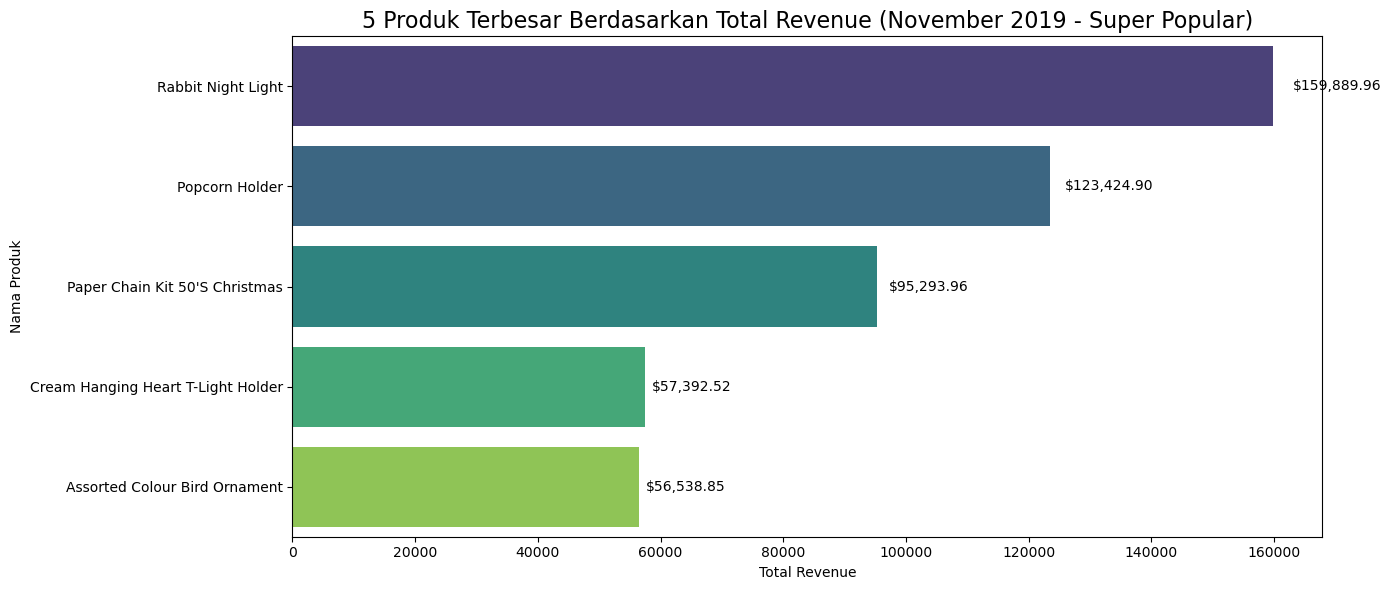

In [8]:
# Ambil 5 produk dengan total revenue terbesar
top5_products_november_2019 = super_popular_nov_sorted.head(5)

# Atur ukuran plot
plt.figure(figsize=(14, 6))

# Buat barplot horizontal dengan `hue`
sns.barplot(
    data=top5_products_november_2019,
    x="Total_Revenue",   # Corrected column name
    y="ProductName",
    hue="ProductName",    # Gunakan ProductName sebagai hue
    dodge=False,          # Pastikan batang tidak tumpang tindih
    palette="viridis"     # Skema warna
)

# Tambahkan teks spesifikasi (jumlah revenue) di setiap batang
for i, row in enumerate(top5_products_november_2019.itertuples()):
    plt.text(row.Total_Revenue + 0.02 * row.Total_Revenue, i, f"${row.Total_Revenue:,.2f}", va='center')

# Hapus legend karena hanya untuk pewarnaan
plt.legend([], [], frameon=False)

# Tambahkan judul dan label
plt.title("5 Produk Terbesar Berdasarkan Total Revenue (November 2019 - Super Popular)", fontsize=16)
plt.xlabel("Total Revenue")
plt.ylabel("Nama Produk")

# Tampilkan plot
plt.tight_layout()
plt.show()

# Apakah barang yang populer di November 2019 sama dengan barang yang populer di July 2019 ?

In [9]:
# Barang yang masuk kategori Popular di November 2019
popular_nov = df_nov_segmented[df_nov_segmented["Final_Category"] == "Popular"]

# Barang yang masuk kategori Popular di July 2019
popular_july = df_july_segmented[df_july_segmented["Final_Category"] == "Popular"]

# Menjawab pertanyaan:
# Apakah barang yang populer di November sama dengan di July?
same_popular = set(popular_nov["ProductNo"]).intersection(set(popular_july["ProductNo"]))


print("\nApakah barang yang populer di November sama dengan di July?")
print(same_popular)


Apakah barang yang populer di November sama dengan di July?
{'21500', '22371', '84212', '20978', '22627', '16156S', '84949', '23291', '72741', '22294', '22745', '21976', '21754', '17003', '22625', '21218', '22212', '84568', '22563', '23545', '22631', '16045', '21770', '84987', '22752', '21670', '22986', '22045', '47503A', '21429', '21558', '22725', '23191', '21329', '21901', '22741', '21669', '22748', '21034', '23186', '75049L', '21755', '22028', '22714', '85175', '22208', '22653', '23302', '23012', '21621', '22776', '22151', '21642', '23089', '22795', '20717', '21430', '22456', '22775', '21650', '22352', '23013', '23546', '21974', '22491', '22339', '22047', '21908', '21327', '21121'}


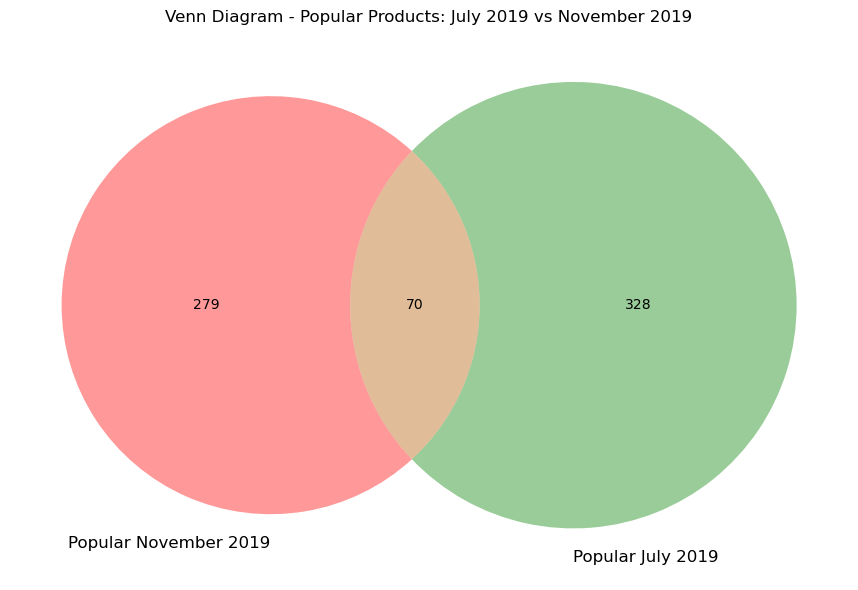

In [10]:
# Data preparation for Venn diagram
popular_nov_set = set(popular_nov["ProductNo"])
popular_july_set = set(popular_july["ProductNo"])


# Create Venn diagram for Popular category comparison
plt.figure(figsize=(10, 6))

# Venn diagram for Popular category
venn2(
    subsets=(len(popular_nov_set), len(popular_july_set), len(popular_nov_set & popular_july_set)),
    set_labels=('Popular November 2019', 'Popular July 2019')
)
plt.title('Venn Diagram - Popular Products: July 2019 vs November 2019')

# Display the plot
plt.tight_layout()
plt.show()


# Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

In [11]:
# Barang yang masuk kategori Super Popular di July 2019
super_popular_july = df_july_segmented[df_july_segmented["Final_Category"] == "Super Popular"]

# Barang yang masuk kategori Super Popular di November 2019
super_popular_nov = df_nov_segmented[df_nov_segmented["Final_Category"] == "Super Popular"]

# Apakah barang yang Super Popular di November sama dengan di July?
same_super_popular = set(super_popular_nov["ProductNo"]).intersection(set(super_popular_july["ProductNo"]))


print("\nApakah barang yang Super Popular di November sama dengan di July?")
print(same_super_popular)


Apakah barang yang Super Popular di November sama dengan di July?
{'22138', '23005', '22697', '84596F', '22041', '22698', '16237', '23245', '22423', '22960', '23243', '85152', '51014A', '23236', '21703', '23308', '22983', '21934', '21929', '84836', '21171', '23307', '23192', '22326', '23078', '20726', '23200', '22385', '23256', '84946', '84970L', '22961', '23240', '23103', '21982', '21918', '47566', '21212', '20712', '82486', '21136', '23309', '23298', '22411', '22417', '20914', '23207', '22727', '21733', '84991', '23168', '23293', '20723', '22554', '23035', '22470', '22630', '22699', '22560', '23204', '21931', '22620', '22952', '22086', '22189', '84596B', '20676', '22993', '23310', '21843', '23284', '23084', '22348', '22355', '79321', '20992', '22112', '22029', '82482', '22621', '20971', '21137', '84879', '22379', '23077', '21985', '22356', '21169', '22661', '23294', '82552', '22555', '21314', '23296', '23322', '22558', '22561', '20718', '22629', '20713', '23188', '23209', '23321', '

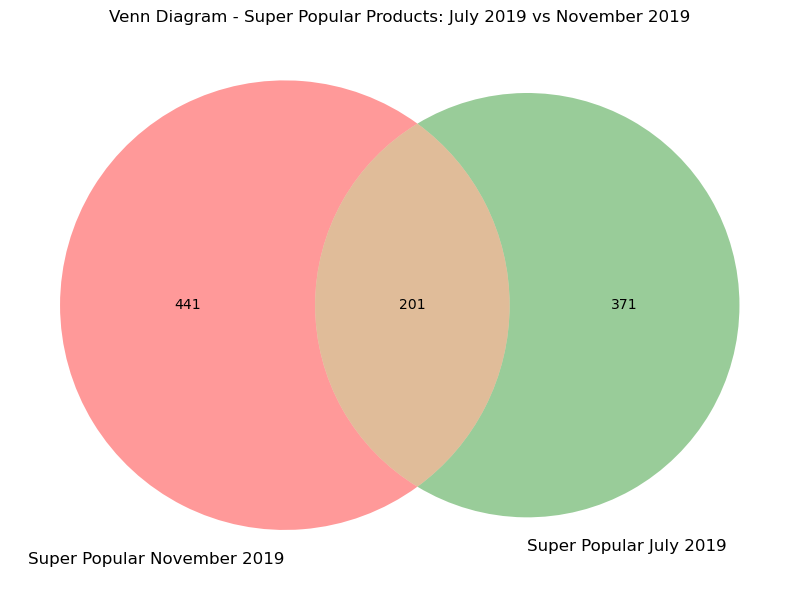

In [12]:
# Data preparation for Venn diagram
super_popular_nov_set = set(super_popular_nov["ProductNo"])
super_popular_july_set = set(super_popular_july["ProductNo"])

# Create Venn diagram for Super Popular category comparison
plt.figure(figsize=(10, 6))

# Venn diagram for Super Popular category
venn2(
    subsets=(len(super_popular_nov_set), len(super_popular_july_set), len(super_popular_nov_set & super_popular_july_set)),
    set_labels=('Super Popular November 2019', 'Super Popular July 2019')
)
plt.title('Venn Diagram - Super Popular Products: July 2019 vs November 2019')

# Display the plot
plt.tight_layout()
plt.show()

Insight:

Overlap Produk Populer di Juli dan November 2019:
Ada 201 produk yang termasuk dalam kategori super populer baik di bulan Juli maupun November, menunjukkan bahwa produk tersebut konsisten diminati oleh pelanggan selama dua bulan tersebut.

Produk Populer di Juli dan November:

Di Juli 2019, ada 371 produk yang sangat populer, tetapi tidak muncul di November 2019.

Sebaliknya, di November 2019, ada 441 produk yang sangat populer, yang tidak ada di Juli 2019. Hal ini bisa menunjukkan adanya tren musiman atau perubahan preferensi pelanggan dari bulan Juli ke November.

Rekomendasi:

Fokus pada Produk yang Populer di Kedua Bulan:
Perkuat pemasaran dan distribusi untuk produk yang muncul di kedua bulan (201 produk) karena produk ini memiliki daya tarik yang konsisten dari pelanggan.

Analisis Perubahan Tren Produk Populer:
Lakukan analisis lebih mendalam tentang produk yang hanya populer di Juli atau November untuk memahami perubahan tren atau musiman yang dapat dimanfaatkan untuk kampanye pemasaran mendatang.

Optimalkan Promosi Produk Baru:
Karena ada banyak produk yang hanya populer di salah satu bulan, pertimbangkan untuk memperkenalkan produk baru pada periode yang tepat berdasarkan tren yang terlihat di bulan Juli atau November untuk memaksimalkan penjualan.

# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini : 

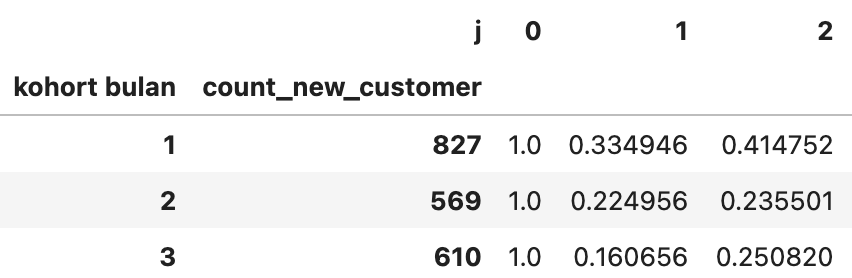

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemduain.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya  

Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019
Petunjuk : 
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

# Pembuatan retention_matrix

In [13]:
# Filter data berdasarkan periode
df_sales_filtered = df_sales[(df_sales["Date"] >= "2019-01-01") & (df_sales["Date"] <= "2019-11-30")].copy()

# Tentukan bulan pertama transaksi (CohortMonth) & bulan transaksi (TransactionMonth)
df_sales_filtered["CohortMonth"] = df_sales_filtered.groupby("CustomerNo")["Date"].transform("min").dt.to_period("M")
df_sales_filtered["TransactionMonth"] = df_sales_filtered["Date"].dt.to_period("M")

# Hitung perbedaan bulan (CohortIndex)
df_sales_filtered["CohortIndex"] = ((df_sales_filtered["TransactionMonth"].dt.year - df_sales_filtered["CohortMonth"].dt.year) * 12 + (df_sales_filtered["TransactionMonth"].dt.month - df_sales_filtered["CohortMonth"].dt.month))

# Buat matriks kohort retensi
cohort_counts = df_sales_filtered.pivot_table(index="CohortMonth", columns="CohortIndex", values="CustomerNo", aggfunc=pd.Series.nunique)

# Hitung jumlah pelanggan baru (count_new_customer)
cohort_sizes = cohort_counts.iloc[:, 0]
retention_matrix = cohort_counts.divide(cohort_sizes, axis=0)

# Tambahkan count_new_customer sebelum normalisasi
retention_matrix.insert(0, "count_new_customer", cohort_sizes)

# Format index agar hanya menampilkan bulan numerik
retention_matrix.index = retention_matrix.index.strftime("%Y-%m")

# Ganti NaN dengan 0 untuk menghindari missing values
retention_matrix = retention_matrix.fillna(0)

# Tampilkan hasil akhir
retention_matrix

CohortIndex,count_new_customer,0,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,,,
2019-01,827.0,1.0,0.334946,0.414752,0.373640,0.436518,0.406288,0.374849,0.368803,0.412334,0.407497,0.494559
2019-02,569.0,1.0,0.224956,0.235501,0.319859,0.300527,0.256591,0.282953,0.312830,0.298770,0.355009,0.000000
2019-03,610.0,1.0,0.160656,0.250820,0.219672,0.242623,0.178689,0.275410,0.244262,0.298361,0.000000,0.000000
2019-04,397.0,1.0,0.224181,0.206549,0.219144,0.201511,0.246851,0.246851,0.294710,0.000000,0.000000,0.000000
2019-05,374.0,1.0,0.184492,0.179144,0.179144,0.213904,0.227273,0.272727,0.000000,0.000000,0.000000,0.000000
2019-06,309.0,1.0,0.184466,0.148867,0.213592,0.216828,0.294498,0.000000,0.000000,0.000000,0.000000,0.000000
2019-07,242.0,1.0,0.152893,0.190083,0.219008,0.301653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08,192.0,1.0,0.197917,0.234375,0.234375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09,312.0,1.0,0.246795,0.339744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


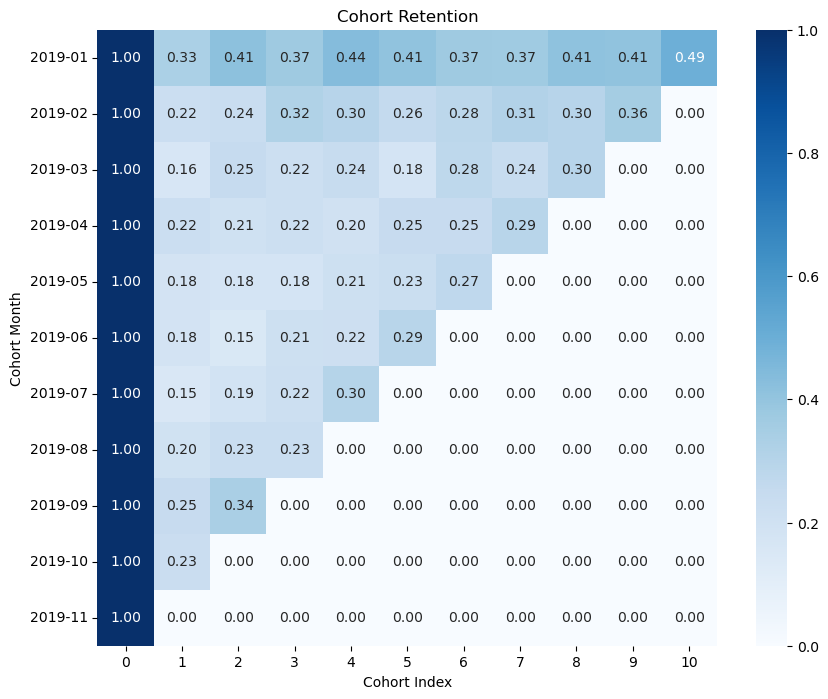

In [14]:
# Buat heatmap
plt.figure(figsize=(10,8))
sns.heatmap(retention_matrix.iloc[:, 1:], annot=True, cmap="Blues", fmt=".2f")
plt.title("Cohort Retention")
plt.xlabel("Cohort Index")
plt.ylabel("Cohort Month")
plt.show()

Insight:

Cohort Januari 2019 menunjukkan performa terbaik dengan tingkat retensi yang tinggi, di mana sebagian besar pengguna tetap aktif hingga 10 bulan. Hal ini menunjukkan bahwa kampanye pemasaran sangat berhasil. Namun, banyak pengguna yang berhenti aktif dalam bulan pertama, terutama setelah cohort Januari 2019. Di cohort-cohort berikutnya, sebagian besar pengguna langsung tidak aktif setelah hanya satu bulan, yang mengindikasikan banyak yang hanya mencoba tanpa melanjutkan penggunaan.

Tingkat retensi semakin menurun dari bulan Mei hingga November 2019. Ini bisa jadi akibat perubahan strategi atau produk yang kurang sesuai dengan kebutuhan pengguna.

Cohort September 2019 mengalami sedikit peningkatan pada bulan kedua, yang cukup jarang terjadi. Kenaikan ini bisa menjadi tanda adanya inisiatif atau perubahan yang berhasil menarik perhatian pengguna.

Rekomendasi (Langkah yang Bisa Diambil):

1. Tiru pendekatan Januari 2019

- Telusuri kembali apa yang dilakukan pada bulan Januari, fitur-fitur yang ditawarkan, strategi pemasaran yang digunakan, dan alasan mengapa pengguna tetap aktif. Replikasi elemen-elemen yang berhasil tersebut.

2. Perbaiki pengalaman onboarding (pengalaman pertama pengguna)

- Pastikan pengguna baru memahami manfaat produk, berikan tutorial singkat, dan arahkan mereka untuk memanfaatkan fitur-fitur utama.

3. Ingatkan pengguna yang hampir berhenti

- Kirim pengingat melalui notifikasi, email, atau tawaran menarik sebelum pengguna memutuskan untuk tidak melanjutkan penggunaan.

4. Evaluasi sumber iklan atau promosi

- Sejak bulan Mei, mungkin sasaran iklan kurang tepat. Fokuskan kembali pada saluran yang mendatangkan pengguna yang lebih berkualitas.

5. Lanjutkan eksperimen yang menunjukkan hasil positif

- Seperti pada cohort September, bisa jadi ada fitur atau kampanye pemasaran yang menarik perhatian pengguna. Identifikasi dan kembangkan percobaan lainnya yang memiliki potensi.



# Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

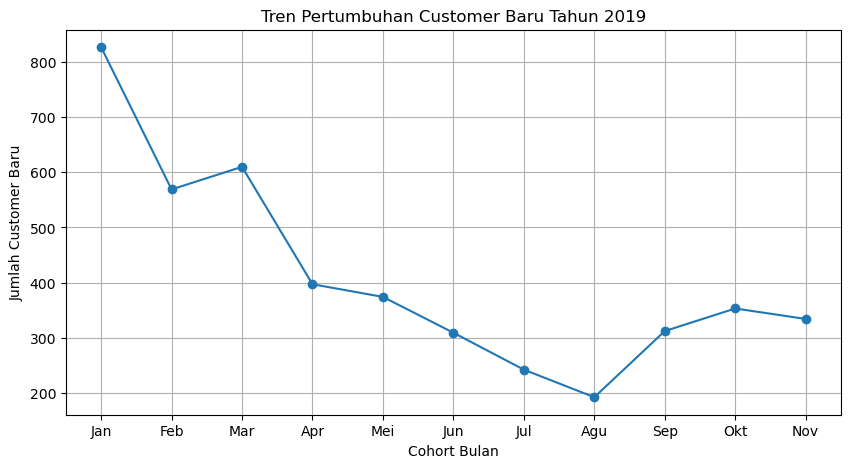

In [15]:
# Ubah format menjadi nama bulan dalam bahasa Indonesia
bulan_indo = {
    "2019-01": "Jan", "2019-02": "Feb", "2019-03": "Mar", "2019-04": "Apr", 
    "2019-05": "Mei", "2019-06": "Jun", "2019-07": "Jul", "2019-08": "Agu", 
    "2019-09": "Sep", "2019-10": "Okt", "2019-11": "Nov", "2019-12": "Des"
}

# Membuat plot
plt.figure(figsize=(10, 5))
plt.plot(retention_matrix.index, retention_matrix["count_new_customer"], marker="o", linestyle="-")

# Menyesuaikan label x menjadi nama bulan
plt.xticks(ticks=range(len(retention_matrix.index)), labels=[bulan_indo.get(x, x) for x in retention_matrix.index])

plt.xlabel("Cohort Bulan")
plt.ylabel("Jumlah Customer Baru")
plt.title("Tren Pertumbuhan Customer Baru Tahun 2019")
plt.grid(True)
plt.show()

### Insight:
1. Penurunan Drastis pada Awal Tahun:
- Terjadi penurunan signifikan dalam jumlah customer baru pada bulan Februari hingga Mei, yang menandakan adanya penurunan minat atau faktor eksternal yang mempengaruhi akuisisi pelanggan baru.

2. Pemulihan pada Pertengahan Tahun:
- Terdapat peningkatan customer baru yang stabil pada bulan Juni hingga Agustus, menunjukkan adanya upaya atau perubahan strategi yang berhasil meningkatkan pertumbuhan pelanggan baru.

3. Stabilitas pada Akhir Tahun:
- Pada bulan-bulan terakhir (September hingga November), jumlah customer baru relatif stabil, dengan sedikit peningkatan menjelang November, yang menunjukkan adanya potensi untuk pertumbuhan lebih lanjut dengan strategi yang tepat.

### Rekomendasi:
1. Perkuat Strategi Akuisisi Pelanggan di Kuartal 1 dan 2:
- Fokuskan upaya pemasaran dan promosi di awal tahun untuk meningkatkan jumlah customer baru, menggunakan data yang ada untuk merancang kampanye yang lebih efektif.

2. Manfaatkan Tren Pertumbuhan di Pertengahan Tahun:
- Evaluasi dan perkuat strategi yang digunakan pada bulan Juni hingga Agustus yang tampaknya berhasil meningkatkan customer baru, untuk diterapkan secara konsisten sepanjang tahun.

3. Optimalkan Strategi Menjelang Akhir Tahun:
- Gunakan momentum yang ada di bulan September hingga November untuk memperkenalkan lebih banyak program loyalitas atau promosi yang dapat mendorong lebih banyak pelanggan baru.

# Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

In [16]:
# Jawaban Nomor 2
# Hitung retention rata-rata per bulan
average_retention = retention_matrix.iloc[:, 2:].mean(axis=1)
average_retention

CohortMonth
2019-01    0.402418
2019-02    0.258699
2019-03    0.187049
2019-04    0.163980
2019-05    0.125668
2019-06    0.105825
2019-07    0.086364
2019-08    0.066667
2019-09    0.058654
2019-10    0.023229
2019-11    0.000000
dtype: float64

In [17]:
# Tampilkan bulan dengan retention tertinggi
best_month = average_retention.idxmax()
best_retention = average_retention.max()

print(f"Bulan dengan retention tertinggi: {best_month}, dengan retention rata-rata {best_retention:.2%}")

Bulan dengan retention tertinggi: 2019-01, dengan retention rata-rata 40.24%


Insigth Jawaban No 1 & 2:
1. Grafik menunjukkan adanya penurunan tren, yang mengindikasikan bahwa laju akuisisi pelanggan baru mulai melambat.
2. Tingkat retensi tertinggi tercatat pada bulan pertama dengan rata-rata 40,24%, yang menunjukkan bahwa kampanye pemasaran di bulan pertama lebih berhasil dalam mempertahankan pengguna.

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

## Pertanyaan 

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  


# Pertanyaan 1 :
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

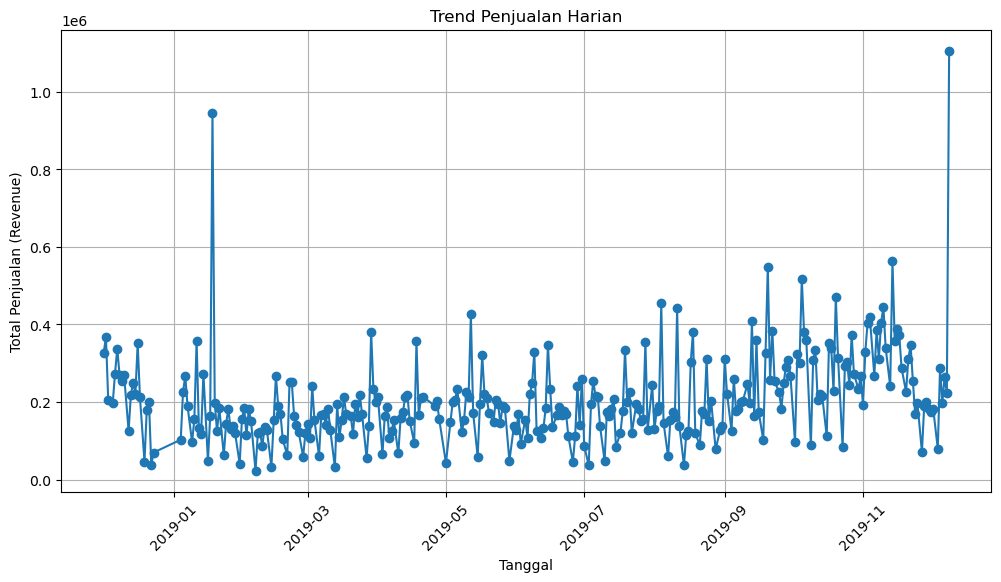

In [18]:
# Nomor 1
# Agregasi total penjualan per hari
daily_sales = df_sales.groupby('Date')['Revenue'].sum()
# Plot trend penjualan harian
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-')
plt.xlabel("Tanggal")
plt.ylabel("Total Penjualan (Revenue)")
plt.title("Trend Penjualan Harian")
plt.xticks(rotation=45)
plt.grid()
plt.show()


Grafik di atas menunjukkan tren total penjualan harian

Analisis Tren:

Secara umum, tren penjualan terlihat berfluktuasi dengan beberapa puncak penjualan pada waktu tertentu. Terlihat ada beberapa lonjakan signifikan, kemungkinan terkait dengan promosi atau kampanye tertentu. Setelah beberapa lonjakan, tren cenderung kembali menurun ke level yang lebih stabil. Secara keseluruhan, tren penjualan tidak menunjukkan peningkatan atau penurunan yang konsisten, melainkan cenderung fluktuatif.

# Pertanyaan 2 :
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.

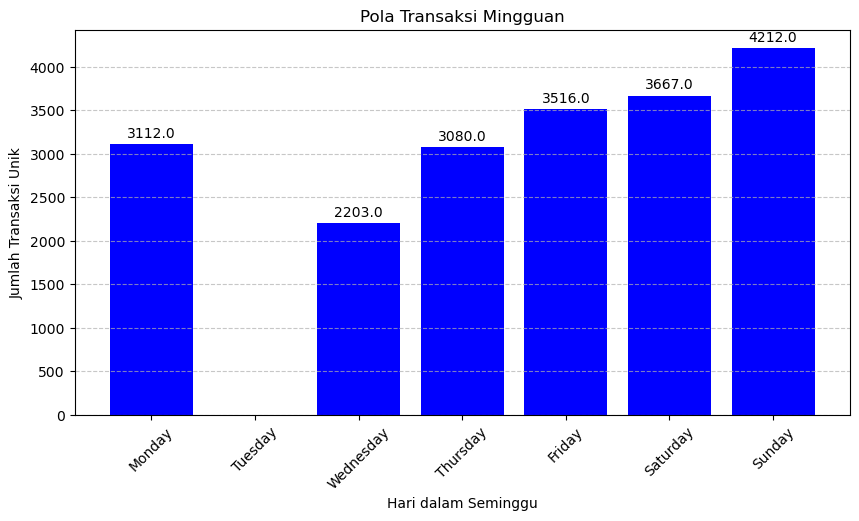

In [19]:
# Nomor 2
# Tambahkan kolom nama hari
df_sales['DayOfWeek'] = df_sales['Date'].dt.day_name()

# Agregasi jumlah transaksi unik per hari dalam seminggu
weekly_pattern = df_sales.groupby('DayOfWeek')['TransactionNo'].nunique()

# Urutkan sesuai urutan hari
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekly_pattern = weekly_pattern.reindex(days_order)

# Plot pola transaksi mingguan
plt.figure(figsize=(10, 5))
plt.bar(range(len(weekly_pattern)), weekly_pattern.values, color='blue')
plt.xlabel("Hari dalam Seminggu")
plt.ylabel("Jumlah Transaksi Unik")
plt.title("Pola Transaksi Mingguan")
plt.xticks(range(len(weekly_pattern)), weekly_pattern.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan angka di atas bar
for i, value in enumerate(weekly_pattern.values):
    if not np.isnan(value):
        plt.text(i, value + max(weekly_pattern.values) * 0.01, str(value), ha='center', va='bottom')

plt.show()

Insight:

- Dari grafik Pola Transaksi Mingguan, terlihat bahwa jumlah transaksi meningkat secara bertahap dari hari Senin hingga Minggu.

- Hari Minggu mencatatkan jumlah transaksi tertinggi dengan 4212 transaksi, sementara Rabu mencatatkan jumlah transaksi terendah dengan 2203 transaksi.

- Hari Senin hingga Sabtu menunjukkan kecenderungan pola transaksi yang cukup konsisten, dengan sedikit peningkatan pada hari-hari tertentu (misalnya Jumat dan Sabtu).

Rekomendasi:

1. Fokus pada Hari Rabu:

- Mengingat Rabu merupakan hari dengan transaksi terendah, bisa dipertimbangkan untuk melakukan kampanye promosi atau diskon yang dapat meningkatkan minat pelanggan pada hari tersebut. Misalnya, memberikan penawaran spesial untuk menarik lebih banyak transaksi di tengah minggu.

2. Optimalkan Transaksi di Akhir Pekan:

- Dengan tingginya volume transaksi di Minggu, pertimbangkan untuk memperkuat strategi pemasaran pada akhir pekan, seperti menargetkan promosi spesial atau meningkatkan kapasitas layanan agar mampu menangani lonjakan transaksi.

3. Analisis Pola Konsisten pada Hari Lain:

- Pola transaksi yang stabil di hari Senin hingga Sabtu dapat dimanfaatkan untuk meningkatkan retensi pelanggan dengan memanfaatkan teknik pemasaran yang lebih personal atau berbasis perilaku pengguna. Ini bisa berupa pemberian rewards untuk transaksi berulang atau penawaran eksklusif bagi pelanggan setia.

In [20]:
# Menghitung barang terjual per hari
orders_per_day = df_sales.groupby("DayOfWeek")["Quantity"].sum().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
print("Total Barang Terjual Per Hari:")
orders_per_day

Total Barang Terjual Per Hari:


DayOfWeek
Monday        904683.0
Tuesday            NaN
Wednesday     470163.0
Thursday      870800.0
Friday       1113434.0
Saturday     1024669.0
Sunday       1207749.0
Name: Quantity, dtype: float64

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

# Produk apa yang paling sering mengalami perubahan harga?

In [21]:
# Menghitung jumlah variasi harga unik per produk menggunakan kolom "Price"
price_variation = df_sales.groupby("ProductName")["Price"].nunique().sort_values(ascending=False)

# Filter produk dengan setidaknya 10 variasi harga unik
frequent_price_changes = price_variation[price_variation >= 10]

# Tampilkan daftar produk dengan variasi harga yang memenuhi kriteria
frequent_price_changes


ProductName
Chilli Lights                        23
Hot Water Bottle Tea And Sympathy    20
Cook With Wine Metal Sign            20
Doormat Red Retrospot                19
Fawn Blue Hot Water Bottle           19
                                     ..
Ribbon Reel Polkadots                10
Pack Of Six Led Tea Lights           10
Pink Vintage Paisley Picnic Bag      10
Dolly Girl Beaker                    10
Plasters In Tin Circus Parade        10
Name: Price, Length: 700, dtype: int64

# Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang. Barang manakah yang memiliki korelasi paling negatif?

In [22]:
# Menghitung korelasi antara harga dan kuantitas untuk setiap produk yang memenuhi kriteria (>= 10 variasi harga)
correlations = {}

for product in frequent_price_changes.index:
    product_data = df_sales[df_sales["ProductName"] == product][["Price", "Quantity"]]
    if len(product_data) > 1:  # Korelasi butuh setidaknya 2 data
        correlation = product_data["Price"].corr(product_data["Quantity"])
        correlations[product] = correlation

# Mengonversi hasil korelasi ke DataFrame dan mengurutkan dari yang paling negatif
correlation_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Correlation"]).sort_values(by="Correlation")

# Mengambil produk dengan korelasi paling negatif
most_negative_correlation = correlation_df.iloc[0]

most_negative_correlation

Correlation   -0.477738
Name: Set Of 2 Tea Towels Ping Microwave, dtype: float64

In [23]:
correlation_df

,Correlation
Set Of 2 Tea Towels Ping Microwave,-0.477738
Squarecushion Cover Pink Union Jack,-0.461947
Large Cake Towel Pink Spots,-0.439484
Bag 500g Swirly Marbles,-0.436841
Pizza Plate In Box,-0.436719
...,...
Set/10 Ivory Polkadot Party Candles,0.130945
6 Gift Tags 50'S Christmas,0.135854
Roll Wrap 50'S Red Christmas,0.138331
3d Traditional Christmas Stickers,0.143960


Produk dengan korelasi paling negatif antara harga dan kuantitas adalah "Set Of 2 Tea Towels Ping Microwave" dengan nilai korelasi sekitar -0.477738.

Artinya, ketika harga produk ini naik, jumlah pembeliannya cenderung turun secara signifikan, dan sebaliknya.

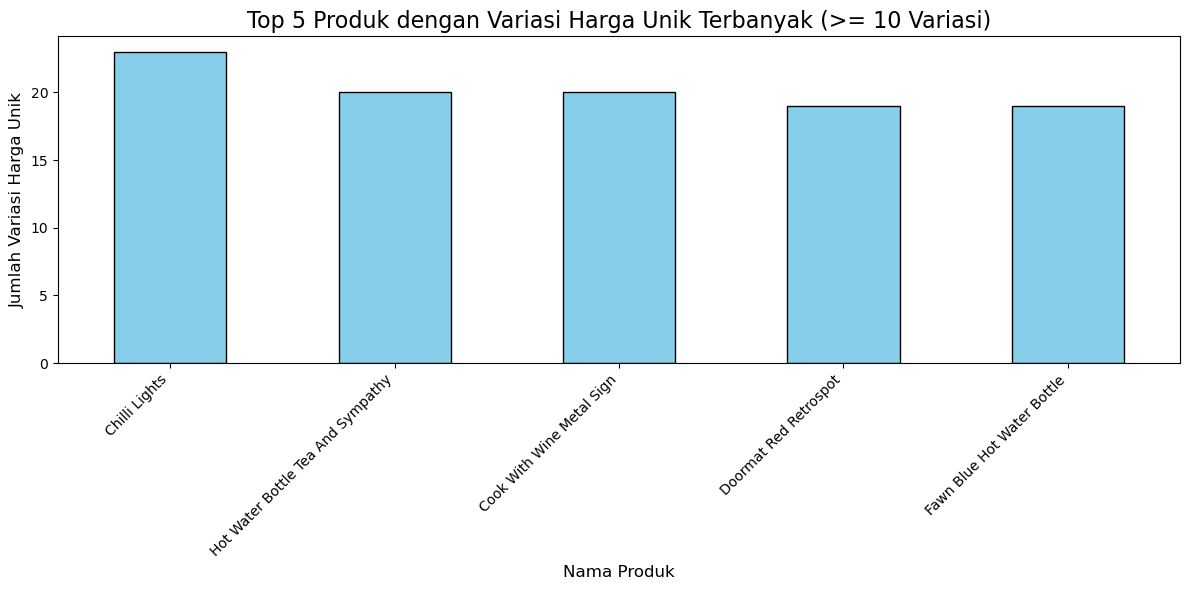

In [24]:
# Membatasi hanya 10 produk dengan variasi harga unik tertinggi
top_5_frequent_price_changes = frequent_price_changes.head(5)

# Visualisasi jumlah variasi harga unik per produk
plt.figure(figsize=(12, 6))
top_5_frequent_price_changes.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Top 5 Produk dengan Variasi Harga Unik Terbanyak (>= 10 Variasi)", fontsize=16)
plt.ylabel("Jumlah Variasi Harga Unik", fontsize=12)
plt.xlabel("Nama Produk", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

# Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya. Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

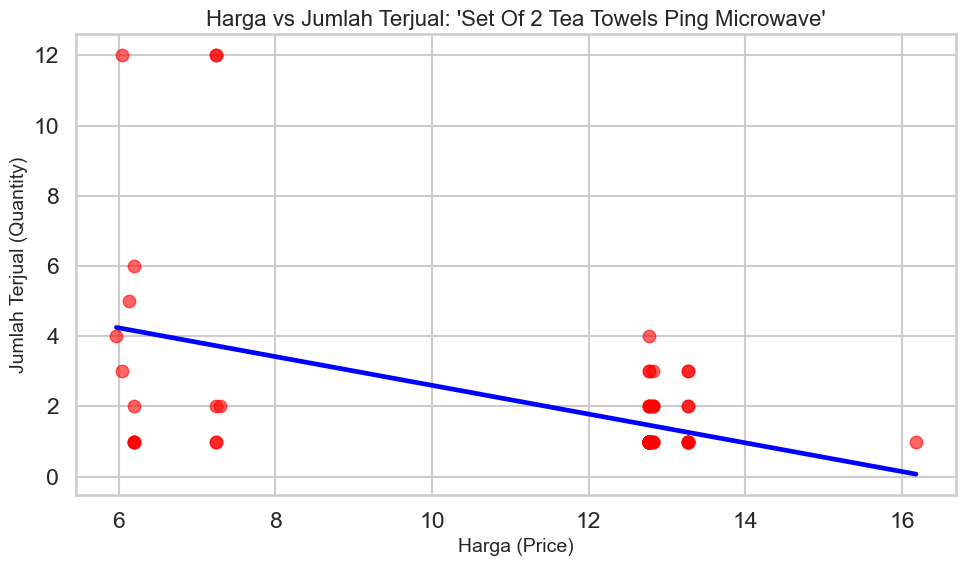

In [25]:
# Set style agar visual lebih menarik
sns.set(style="whitegrid", context="talk")

# Filter data untuk produk dengan korelasi paling negatif
product_name = "Set Of 2 Tea Towels Ping Microwave"
product_data = df_sales[df_sales["ProductName"] == product_name][["Price", "Quantity"]]

# Buat scatter plot dengan garis regresi
plt.figure(figsize=(10, 6))
sns.regplot(
    x="Price",
    y="Quantity",
    data=product_data,
    scatter_kws={'alpha': 0.6, 'color': 'red'},
    line_kws={'color': 'blue'},
    ci=None
)

plt.title(f"Harga vs Jumlah Terjual: '{product_name}'", fontsize=16)
plt.xlabel("Harga (Price)", fontsize=14)
plt.ylabel("Jumlah Terjual (Quantity)", fontsize=14)
plt.tight_layout()
plt.show()

Produk "Set Of 2 Tea Towels Ping Microwave" memiliki korelasi yang cukup negatif antara harga dan jumlah penjualan. Artinya, ketika harga produk ini naik, pelanggan cenderung membeli dalam jumlah lebih sedikit.

Jika harga produk ini dinaikkan, kemungkinan besar penjualan (dalam jumlah unit) akan menurun secara signifikan, karena pelanggan sensitif terhadap perubahan harga pada produk ini.

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh : 
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.

## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

# Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?

In [27]:
# Tambahkan kolom total harga per baris produk
df_sales["TotalPrice"] = df_sales["Price"] * df_sales["Quantity"]

# Hitung total GMV per transaksi
gmv_per_transaction = df_sales.groupby(["DayOfWeek", "TransactionNo"]).agg({
    "TotalPrice": "sum",
    "Country": "first",
    "CustomerNo" : "first"
}).reset_index()

# Hitung GMV total dan jumlah transaksi per hari
basket_size_per_day = gmv_per_transaction.groupby("DayOfWeek").agg({
    "TotalPrice": ["sum", "mean", "count"]
}).reset_index()

basket_size_per_day.columns = ["Day", "Total_GMV", "Avg_Basket_Size", "Total_Transactions"]

In [28]:
gmv_per_transaction

,DayOfWeek,TransactionNo,TotalPrice,Country,CustomerNo
0,Friday,537446,2643.28,United Kingdom,18055.0
1,Friday,537447,708.58,United Kingdom,13963.0
2,Friday,537448,102.12,United Kingdom,17450.0
3,Friday,537456,10034.58,United Kingdom,17450.0
4,Friday,537457,11055.98,United Kingdom,17511.0
...,...,...,...,...,...
19785,Wednesday,580533,111.42,United Kingdom,13098.0
19786,Wednesday,580534,451.16,France,12724.0
19787,Wednesday,580535,259.72,United Kingdom,16988.0
19788,Wednesday,580536,1540.08,France,12490.0


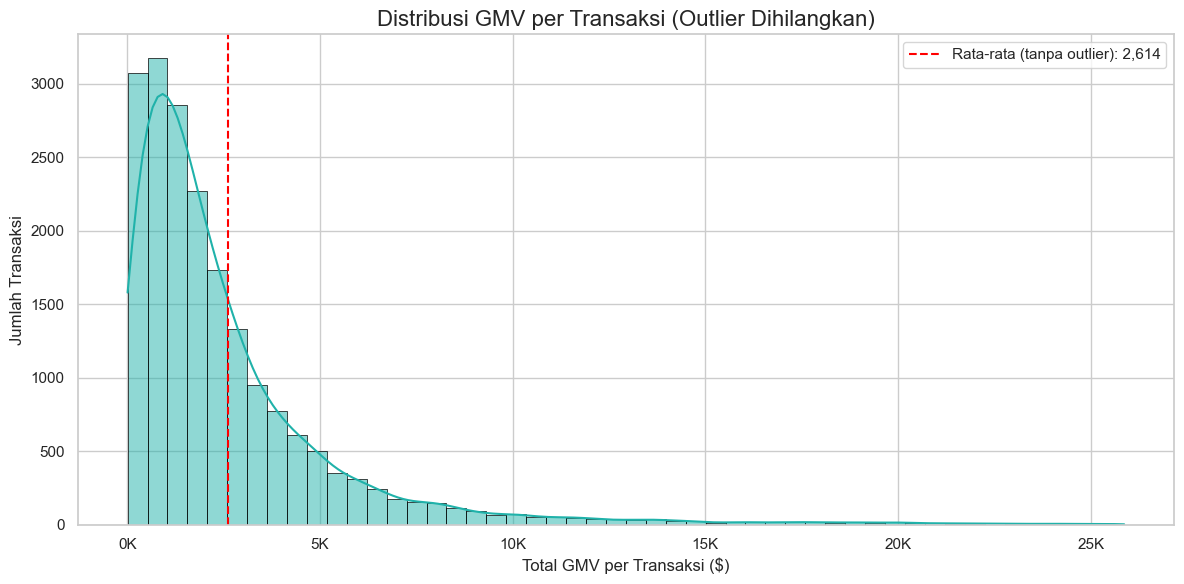

In [29]:
# 1. Hitung batas outlier: ambil hanya transaksi < 99th percentile
threshold = gmv_per_transaction["TotalPrice"].quantile(0.99)

# 2. Buat data yang difilter
filtered_gmv = gmv_per_transaction[gmv_per_transaction["TotalPrice"] <= threshold]

# 3. Visualisasi histogram setelah outlier difilter
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

sns.histplot(
    data=filtered_gmv,
    x="TotalPrice",
    bins=50,
    kde=True,
    color="lightseagreen",
    edgecolor="black",
    linewidth=0.5
)

# 4. Garis rata-rata GMV (setelah filter)
mean_value_filtered = filtered_gmv["TotalPrice"].mean()
plt.axvline(mean_value_filtered, color='red', linestyle='--', linewidth=1.5,
            label=f'Rata-rata (tanpa outlier): {mean_value_filtered:,.0f}')

# 5. Format sumbu X agar mudah dibaca
import matplotlib.ticker as mtick
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}K'))

# 6. Label dan legend
plt.title("Distribusi GMV per Transaksi (Outlier Dihilangkan)", fontsize=16)
plt.xlabel("Total GMV per Transaksi ($)", fontsize=12)
plt.ylabel("Jumlah Transaksi", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

Insight:

1.	Mayoritas Transaksi Bernilai Rendah
- Sebagian besar transaksi terjadi di bawah $1.000.
- Volume transaksi tinggi pada GMV kecil menunjukkan kemungkinan tingginya pembelian produk murah atau banyaknya transaksi mikro.

2.	Rata-Rata GMV Relatif Rendah ($2.614)
- Ini menunjukkan bahwa meskipun ada transaksi dengan nilai tinggi, secara umum kontribusi mereka terhadap rata-rata cukup kecil.
- Penyaringan outlier penting agar rata-rata ini tidak bias oleh segelintir transaksi besar.

3.	Distribusi yang Skewed (Pencilan Ada di Ekstrem Kanan)
- Potensi adanya segmen pelanggan eksklusif atau produk premium yang menyumbang GMV tinggi tapi dalam jumlah transaksi kecil.
- Analisis segmentasi pelanggan lebih lanjut dapat membantu memisahkan strategi untuk segmen nilai tinggi dan rendah.


Rekomendasi:

1.	Fokus pada Skala Mikro
- Perbanyak promosi dan kemudahan transaksi kecil (misal: bundling murah, diskon minimal transaksi).
- Pertimbangkan fitur “repeat order” atau “auto-repurchase” untuk produk murah dan cepat habis.

2.	Segmentasi Pelanggan Berdasarkan GMV
- Identifikasi pelanggan dengan GMV tinggi meski jumlah mereka kecil.
- Tawarkan layanan eksklusif seperti program loyalitas atau personalisasi.

3.	Optimasi Produk Bernilai Tinggi
- Meskipun sedikit, transaksi GMV tinggi bisa jadi margin besar. Evaluasi lebih lanjut produk apa saja yang berkontribusi besar terhadap total GMV.

4.	Pertimbangkan Skema Upselling
- Karena sebagian besar transaksi bernilai rendah, ada peluang untuk meningkatkan nilai transaksi per pelanggan melalui upselling atau cross-selling.

5.	Monitoring Konsisten terhadap Outlier
- Jangan abaikan outlier, justru pantau terus karena bisa memberi sinyal adanya peluang besar atau potensi penipuan/transaksi anomali.


In [32]:
basket_size_per_day

,Day,Total_GMV,Avg_Basket_Size,Total_Transactions
0,Friday,12703501.12,3613.054926,3516
1,Monday,10305826.75,3311.640987,3112
2,Saturday,11223746.52,3060.743529,3667
3,Sunday,13511871.24,3207.946638,4212
4,Thursday,9879295.89,3207.563601,3080
5,Wednesday,5341732.82,2424.753890,2203


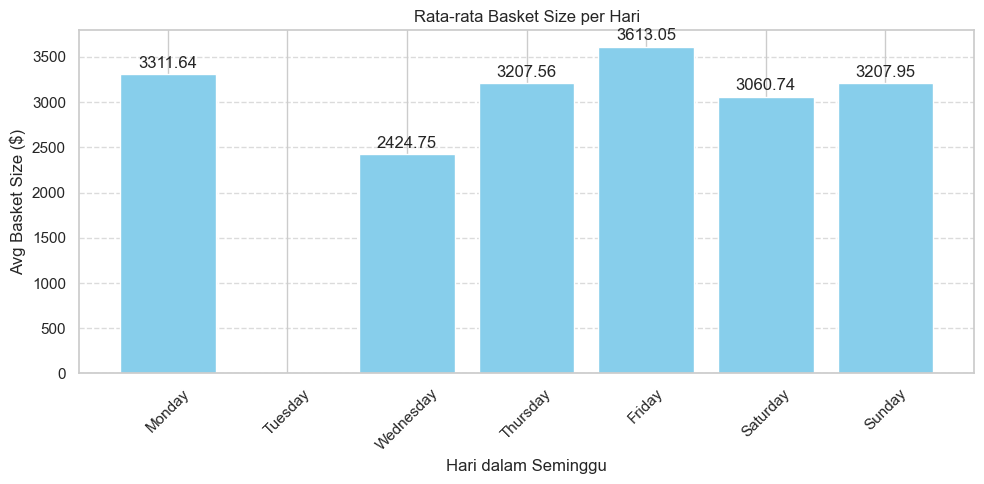

In [33]:
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

basket_size_per_day["Day"] = pd.Categorical(
    basket_size_per_day["Day"], 
    categories=ordered_days, 
    ordered=True
)

data = basket_size_per_day.set_index("Day").reindex(ordered_days)
y = data["Avg_Basket_Size"].values

# Plotting seperti sebelumnya
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.bar(range(len(ordered_days)), y, color='skyblue')
plt.xlabel("Hari dalam Seminggu")
plt.ylabel("Avg Basket Size ($)")
plt.title("Rata-rata Basket Size per Hari")
plt.xticks(range(len(ordered_days)), ordered_days, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(y):
    if not np.isnan(value):
        plt.text(i, value + np.nanmax(y)*0.01, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Insight:

1.	Hari Jumat Memiliki Basket Size Tertinggi
- Rata-rata basket size $3,613.05, tertinggi dibanding hari lainnya.
- Mungkin berkaitan dengan pelanggan yang berbelanja dalam jumlah besar menjelang akhir pekan.
  
2.	Hari Rabu Memiliki Basket Size Terendah
- Rata-rata hanya $2,424.75, paling rendah dalam seminggu.
- Bisa jadi karena pelanggan tidak antusias berbelanja di tengah minggu (weekday fatigue), atau tidak ada promo spesifik.
  
3.	Pola Konsisten di Hari Kerja
- Selain Rabu, hari kerja cenderung memiliki basket size tinggi (Senin, Kamis, dan Jumat di atas $3,200).
- Indikasi bahwa pengguna aktif belanja saat weekday, khususnya awal dan akhir minggu.
  
4.	Akhir Pekan Tetap Stabil
- Sabtu dan Minggu memiliki basket size sedang (3,060.74 dan 3,207.95), menunjukkan tetap ada aktivitas belanja yang signifikan saat weekend.


Rekomendasi:

1.	Optimalkan Promosi di Hari Rabu
- Karena merupakan titik lemah dalam seminggu, pertimbangkan campaign khusus di hari Rabu seperti "Midweek Madness", diskon terbatas, atau flash sale.
  
2.	Manfaatkan Momentum Hari Jumat
- Hari dengan performa terbaik bisa dimaksimalkan untuk campaign besar, upselling, bundling, atau peluncuran produk baru.
- Push notifikasi khusus "Big Friday Deal" bisa digunakan untuk dorong lebih banyak transaksi.
  
3.	Segmentasi dan Personalization Berdasarkan Hari
- Pelanggan yang belanja di weekday vs weekend bisa punya perilaku berbeda.
- Kirim email atau push notification yang relevan sesuai kebiasaan harian mereka.
  
4.	Perkuat Sabtu dan Minggu dengan Mobile-Friendly Campaign
- Karena weekend pengguna mungkin lebih aktif via mobile, buat kampanye yang lebih visual dan instan (seperti gamifikasi, story ads, atau kupon langsung).


# Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

In [34]:
# Hitung GMV rata-rata per transaksi per negara
basket_by_country = gmv_per_transaction.groupby("Country")["TotalPrice"].mean().reset_index()
basket_by_country.columns = ["Country", "Avg_Basket_Size"]
basket_by_country

,Country,Avg_Basket_Size
0,Australia,16058.192097
1,Austria,6286.114545
2,Bahrain,1613.430000
3,Belgium,2805.483299
4,Brazil,4652.270000
5,Canada,6098.182000
6,Channel Islands,4170.966957
7,Cyprus,5195.562500
8,Czech Republic,3837.220000
9,Denmark,4813.523333


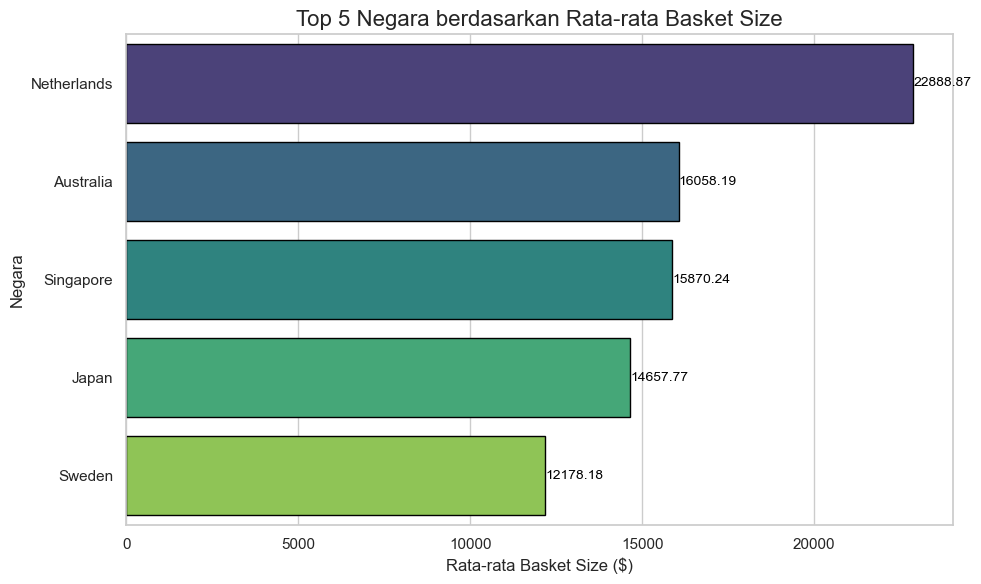

In [35]:
# Ambil 5 negara dengan basket size rata-rata tertinggi
top5_countries = basket_by_country.sort_values("Avg_Basket_Size", ascending=False).head(5)
# Visualisasi bar chart horizontal
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top5_countries,
    x="Avg_Basket_Size",
    y="Country",
    hue="Country",      # Menambahkan `hue` untuk menghindari FutureWarning
    dodge=False,        # Supaya warna tetap statis
    palette="viridis",
    edgecolor="black",
    legend=False        # Hilangkan legend karena tidak diperlukan
)

# Menambahkan nilai angka di setiap bar
for index, value in enumerate(top5_countries["Avg_Basket_Size"]):
    plt.text(value + 0.05, index, f'{value:.2f}', va='center', fontsize=10, color="black")

# Menambahkan judul dan label
plt.title("Top 5 Negara berdasarkan Rata-rata Basket Size", fontsize=16)
plt.xlabel("Rata-rata Basket Size ($)", fontsize=12)
plt.ylabel("Negara", fontsize=12)

plt.tight_layout()
plt.show()

Insight:

1.	Netherlands Mendominasi Secara Signifikan
- Dengan rata-rata basket size $22,888.87, jauh melampaui negara lainnya.
- Kemungkinan menunjukkan pelanggan dengan daya beli tinggi, pembelian dalam jumlah besar, atau fokus pada kategori premium.

2.	Australia dan Singapore Posisi Kedua & Ketiga
- Basket size masing-masing $16,058.19 dan $15,870.24 — cukup dekat satu sama lain.
- Menandakan perilaku belanja serupa, mungkin pasar matang dengan frekuensi belanja menengah tapi nilai tinggi.

3.	Sweden dan Japan Terendah dalam Top 5
- Meski lebih rendah ($12,178.18 dan $14,657.77), mereka tetap berada di atas banyak negara lainnya secara keseluruhan.
- Tetap menjadi pasar penting, namun mungkin perilaku konsumennya lebih konservatif dalam jumlah pembelian per transaksi.

Rekomendasi

1. Fokus Pemasaran & Aktivasi di Netherlands
- Karena memiliki basket size paling tinggi, ini adalah pasar premium yang sangat potensial.
- Gunakan strategi high-touch seperti:
- Penawaran eksklusif
- Produk premium
- Program loyalitas berbasis nilai belanja
  
2. Perkuat Penetrasi di Australia & Singapore
- Keduanya menunjukkan nilai basket besar, cocok untuk strategi:
- Cross-selling dan bundling
- Promosi seasonal berbasis event lokal
- Peningkatan customer retention
  
3. Sesuaikan Strategi Produk untuk Japan & Sweden
- Dengan basket size yang relatif lebih kecil (namun tetap tinggi), pendekatan bisa berupa:
- Optimasi pricing dan produk paket (value-for-money)
- Fokus pada kategori produk paling laku berdasarkan preferensi lokal
  
4. Analisis Lanjutan: Segmentasi Pelanggan Per Negara
- Apakah basket size besar karena frekuensi rendah tapi nilai tinggi, atau pelanggan setia?
- Hal ini akan mempengaruhi apakah strategi retensi atau akuisisi lebih efektif.
  
5. Evaluasi Faktor Eksternal
- Perbedaan ini bisa dipengaruhi oleh:
- Kurs mata uang
- Biaya pengiriman
- Pajak dan regulasi lokal
- Produk yang tersedia per negara


In [36]:
from scipy.stats import f_oneway

# Contoh ANOVA untuk 3 negara
grouped = [group["TotalPrice"].values for name, group in gmv_per_transaction.groupby("Country")]
anova_result = f_oneway(*grouped)
print(anova_result)

F_onewayResult(statistic=12.575939733677743, pvalue=1.72487014336337e-74)


In [37]:
print("F = 12.58 dan p-value = 1.72e-74 (sangat kecil, jauh di bawah 0.05). ")
print("Kesimpulan: Ada perbedaan rata-rata yang signifikan secara statistik di antara kelompok-kelompok yang diuji.")

F = 12.58 dan p-value = 1.72e-74 (sangat kecil, jauh di bawah 0.05). 
Kesimpulan: Ada perbedaan rata-rata yang signifikan secara statistik di antara kelompok-kelompok yang diuji.


# Crucial Question

Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  
Anda dapat menggunakan analisis yang sudah dikerjakan pada bagian sebelumnya, ataupun melakukan analisis baru untuk menjawab pertanyaan dibawah.

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

1. Bagaimana tren penjualan selama beberapa bulan?
2. Produk apa yang paling sering dibeli?
3. Berapa banyak produk yang dibeli pelanggan dalam setiap transaksi?
4. Segmen pelanggan apa yang paling menguntungkan?
5. Berdasarkan temuan Anda, strategi apa yang dapat Anda rekomendasikan kepada bisnis untuk mendapatkan lebih banyak keuntungan?

# Bagaimana tren penjualan selama beberapa bulan?

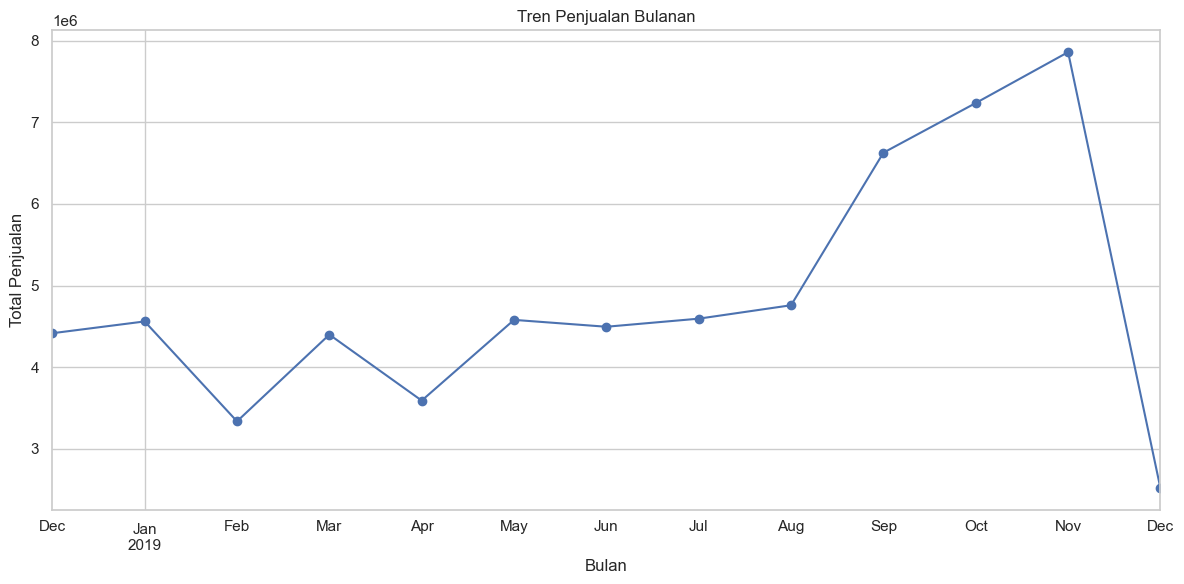

In [38]:
df_sales.loc[:, "TotalSales"] = df_sales['Price'] * df_sales['Quantity']
# 3. Kelompokkan berdasarkan bulan dan hitung total penjualan
monthly_sales = df_sales.resample('ME', on='Date')['TotalSales'].sum()

# 4. Plot tren penjualan bulanan
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title("Tren Penjualan Bulanan")
plt.xlabel("Bulan")
plt.ylabel("Total Penjualan")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# Find the last transaction date
last_transaction_date = df_sales['Date'].max()

last_transaction_date

Timestamp('2019-12-09 00:00:00')

1. Bagaimana tren penjualan sepanjang bulan?

Tren penjualan selama tahun 2019 menunjukkan beberapa pergerakan yang signifikan:

- Penjualan cenderung stabil dari Januari hingga Agustus.
- Terjadi lonjakan yang cukup besar mulai bulan September, dengan puncak pada bulan November.
- Di bulan Desember, terjadi penurunan yang tajam, Hal ini disebabkan oleh data untuk bulan Desember yang hanya tersedia hingga tanggal 9, sehingga data tersebut belum lengkap.

Insight: Peningkatan besar pada kuartal keempat (September–November) menandakan adanya faktor musiman seperti meningkatnya belanja akhir tahun atau adanya promosi besar-besaran.

Rekomendasi:
1. Meningkatkan Penjualan di Bulan Sepi:
- Untuk mengurangi fluktuasi yang terlalu besar, disarankan untuk merancang promosi atau strategi pemasaran yang dapat menjaga penjualan tetap stabil sepanjang tahun, khususnya di bulan-bulan seperti Januari hingga Oktober yang cenderung lebih sepi.
2. Strategi Pengelolaan Stok:
- Berdasarkan lonjakan penjualan yang terjadi pada bulan November dan Desember, disarankan untuk mempersiapkan stok dengan lebih baik menjelang periode ini agar tidak terjadi kehabisan produk atau kesulitan pemenuhan permintaan.
3. Penguatan Loyalitas Pelanggan:
- Mengingat penurunan drastis setelah lonjakan, fokus pada membangun loyalitas pelanggan pasca-promosi bisa menjadi kunci untuk mempertahankan pelanggan dan meningkatkan penjualan di luar periode puncak.

# Produk apa yang paling sering dibeli?

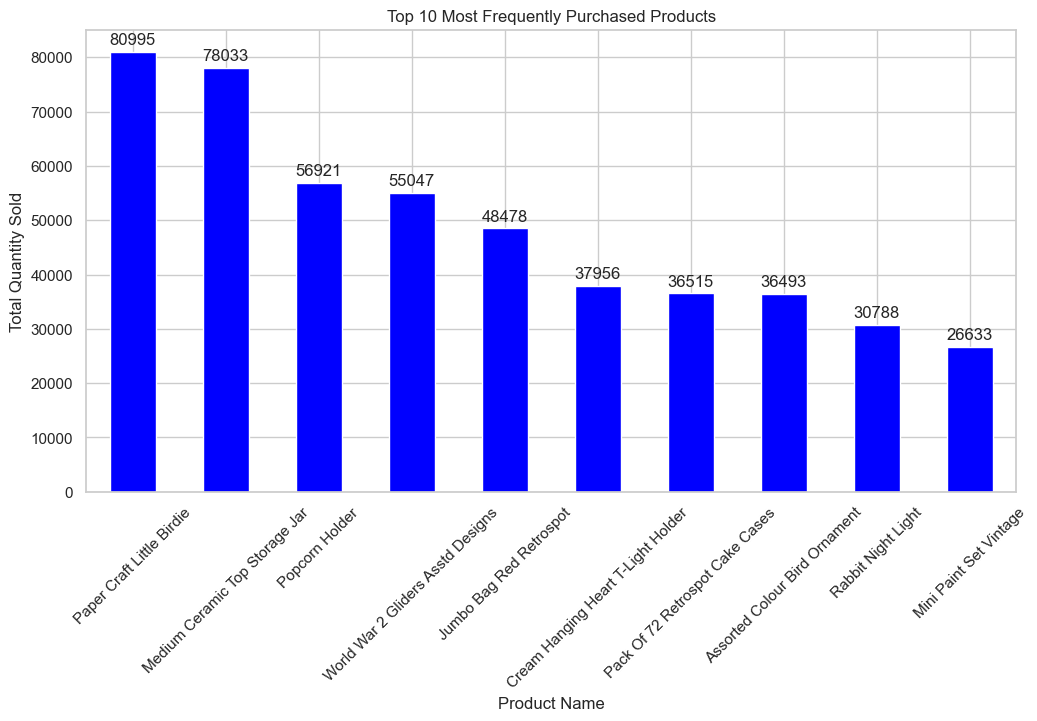

In [40]:
# Jawaban No. 2 (Melihat Produk Yang sering dibeli)
# Agregasi jumlah produk yang terjual
top_products = df_sales.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot produk terlaris
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='blue')
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)

# Tambahkan angka di atas bar
for i, value in enumerate(top_products.values):
    plt.text(i, value + (max(top_products.values) * 0.01), str(value), ha='center', va='bottom')

plt.show()

2. Apa saja produk yang paling sering dibeli?
Produk yang paling banyak dibeli adalah:
- Paper Craft Little Birdie (80,995 unit)
- Medium Ceramic Top Storage Jar (78,033 unit)
- Popcorn Holder (56,921 unit) dan seterusnya hingga Mini Paint Set Vintage.

Insight: Produk-produk yang bersifat dekoratif dan fungsional tampaknya lebih diminati oleh pelanggan. Hal ini dapat dijadikan fokus dalam pengembangan strategi pemasaran dan perencanaan pengadaan stok.

# Berapa banyak produk yang dibeli pelanggan dalam setiap transaksi?

In [41]:
# Jumlah total produk per transaksi (jumlah item yang dibeli dalam satu checkout)
products_per_transaction = df_sales.groupby("TransactionNo")["Quantity"].sum().reset_index()
products_per_transaction.columns = ["TransactionNo", "TotalProducts"]

# Statistik deskriptif
print("\nStatistik deskriptif:")
print(products_per_transaction["TotalProducts"].describe())



Statistik deskriptif:
count    19790.000000
mean       282.541587
std        962.577651
min          1.000000
25%         71.000000
50%        153.000000
75%        298.000000
max      80995.000000
Name: TotalProducts, dtype: float64


 Kesimpulan Statistik deskriptif:
- Mayoritas pelanggan membeli antara 71–298 produk per transaksi (interkuartil).
- Rata-rata pembelian adalah sekitar 283 produk per transaksi.
- Ada outlier besar (80.995 produk dalam satu transaksi), kemungkinan pembelian borongan.
- Median (153) jauh lebih rendah dari mean (283) → distribusi data ini positif skewed (miring ke kanan karena outlier besar).

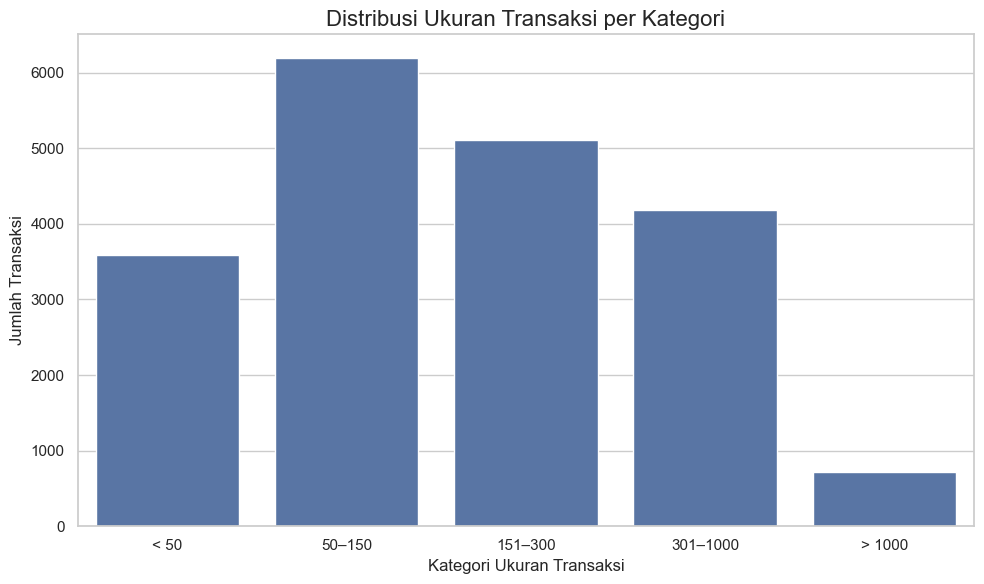

In [42]:
# Buat kategori ukuran transaksi
bins = [0, 50, 150, 300, 1000, float('inf')]
labels = ["< 50", "50–150", "151–300", "301–1000", "> 1000"]
products_per_transaction['TransactionSize'] = pd.cut(products_per_transaction["TotalProducts"], bins=bins, labels=labels)

# Hitung jumlah transaksi per kategori
txn_size_counts = products_per_transaction["TransactionSize"].value_counts().sort_index()

# Visualize the distribution of transaction sizes using a bar plot
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x=txn_size_counts.index, y=txn_size_counts.values,)

# Adding labels and title
plt.title('Distribusi Ukuran Transaksi per Kategori', fontsize=16)
plt.xlabel('Kategori Ukuran Transaksi', fontsize=12)
plt.ylabel('Jumlah Transaksi', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


# Segmen pelanggan apa yang paling menguntungkan?


In [43]:
# Hitung total nilai pembelian per pelanggan
customer_profit = df_sales.groupby("CustomerNo")["Revenue"].sum().reset_index()
customer_profit.columns = ["CustomerNo", "TotalPurchase"]

# Tambahkan informasi negara (gunakan mode agar tiap customer punya 1 negara yang dominan)
customer_country = df_sales.groupby("CustomerNo")["Country"].agg(lambda x: x.mode()[0]).reset_index()
customer_segmentation = pd.merge(customer_profit, customer_country, on="CustomerNo")

# Urutkan berdasarkan TotalPurchase
top_customers = customer_segmentation.sort_values(by="TotalPurchase", ascending=False)

# Tampilkan 10 pelanggan paling menguntungkan
top_customers.head(10)

,CustomerNo,TotalPurchase,Country
1880,14646.0,2112282.03,Netherlands
3302,16446.0,1002741.57,United Kingdom
2085,14911.0,914633.52,EIRE
126,12415.0,900545.54,Australia
4581,18102.0,897137.36,United Kingdom
4082,17450.0,891438.53,United Kingdom
68,12346.0,840113.80,United Kingdom
1506,14156.0,694965.02,EIRE
1140,13694.0,646116.78,United Kingdom
4127,17511.0,639006.19,United Kingdom


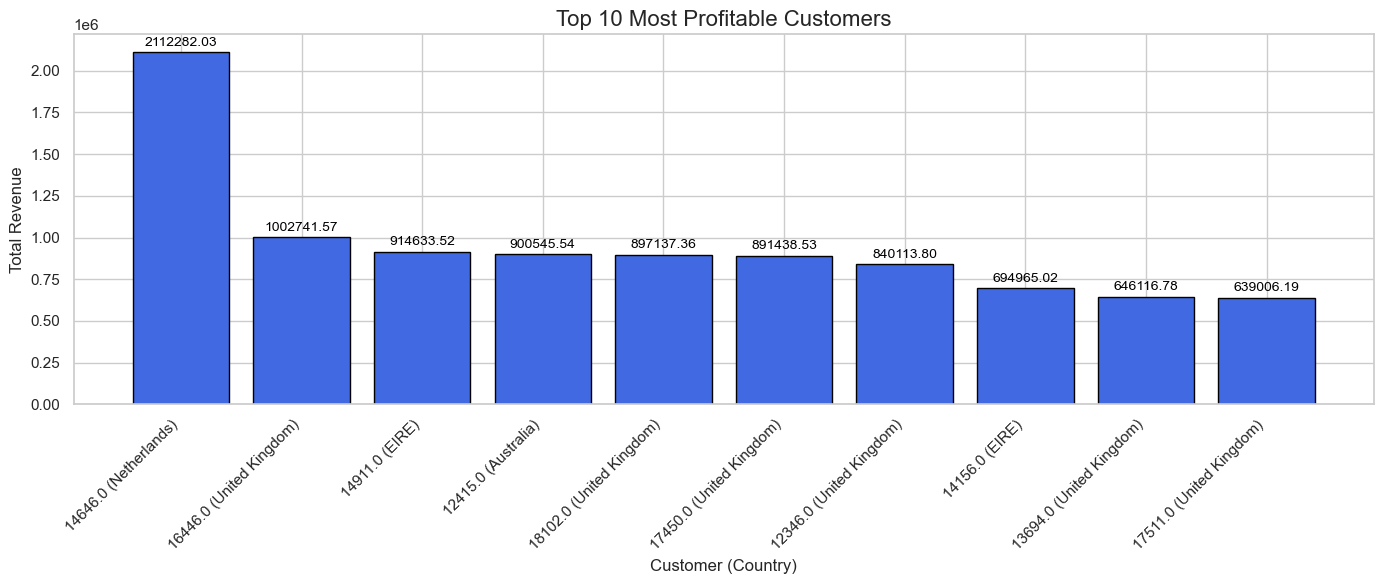

In [44]:
# Buat label baru: CustomerNo (Country)
top_10_customers = top_customers.head(10).copy()
top_10_customers["Label"] = top_10_customers["CustomerNo"].astype(str) + " (" + top_10_customers["Country"] + ")"

# --- Visualisasi ---

plt.figure(figsize=(14, 6))
bars = plt.bar(
    top_10_customers["Label"], 
    top_10_customers["TotalPurchase"], 
    color="royalblue",
    edgecolor="black"
)

plt.title('Top 10 Most Profitable Customers', fontsize=16)
plt.xlabel('Customer (Country)', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Tambahkan angka di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        yval + (max(top_10_customers["TotalPurchase"]) * 0.01), 
        f'{yval:.2f}',
        ha='center', va='bottom', fontsize=10, color="black"
    )

plt.tight_layout()
plt.show()

#### Mengecek Customer Belanda

In [45]:
# Filter the dataset for all transactions from customer 14646
customer_14646_transactions = df_sales[df_sales['CustomerNo'] == 14646]

# Display all transactions for customer 14646
print(customer_14646_transactions)

       TransactionNo       Date ProductNo                        ProductName  \
4024          581338 2019-12-08     23344           Jumbo Bag 50'S Christmas   
8486          581175 2019-12-07     22973       Children's Circus Parade Mug   
8487          581175 2019-12-07     23280  Folding Butterfly Mirror Hot Pink   
8488          581175 2019-12-07     23281       Folding Butterfly Mirror Red   
8489          581175 2019-12-07     23498              Classic Bicycle Clips   
...              ...        ...       ...                                ...   
497157        539491 2018-12-20    47599A                    Pink Party Bags   
497158        539491 2018-12-20     22331   Woodland Party Bag + Sticker Set   
497159        539491 2018-12-20     22333  Retrospot Party Bag + Sticker Set   
497160        539491 2018-12-20     22315       200 Red + White Bendy Straws   
497161        539491 2018-12-20     22445      Pencil Case Life Is Beautiful   

        Price  Quantity  CustomerNo    

In [46]:
print("Customer 14646 memiliki transaksi sejumlah")
print(len(customer_14646_transactions))

Customer 14646 memiliki transaksi sejumlah
2064


In [47]:
jumlah_pelanggan_Belanda = df_sales[df_sales["Country"] == "Netherlands"]["CustomerNo"].nunique()
print("Jumlah Pelanggan Pada Negara Belanda :")
print(jumlah_pelanggan_Belanda)

Jumlah Pelanggan Pada Negara Belanda :
9


In [48]:
# Group by CustomerNo, lalu jumlahkan Revenue per customer di Belanda
total_revenue_per_customer_belanda = (
    df_sales[df_sales["Country"] == "Netherlands"]
    .groupby("CustomerNo")["Revenue"]
    .sum()
    .reset_index()
    .sort_values(by="Revenue", ascending=False)
)

total_revenue_per_customer_belanda

,CustomerNo,Revenue
8,14646.0,2112282.03
0,12759.0,10370.70
1,12775.0,10229.43
2,12778.0,9084.33
7,12802.0,3605.02
3,12787.0,2723.08
5,12790.0,1983.08
6,12791.0,1166.40
4,12789.0,109.52


In [49]:
# Jika ingin menyertakan nama negara sebagai segmen tambahan:
customer_country = df_sales.groupby(["CustomerNo", "Country"])["Revenue"].sum().reset_index()

# Ambil segmen (negara) paling menguntungkan
top_segments = customer_country.groupby("Country")["Revenue"].sum().sort_values(ascending=False)
print("\nSegmen Negara Paling Menguntungkan:")
print(top_segments.head(5))


Segmen Negara Paling Menguntungkan:
Country
United Kingdom    52524576.47
Netherlands        2151553.59
EIRE               1713410.95
Germany            1371543.27
France             1330652.89
Name: Revenue, dtype: float64


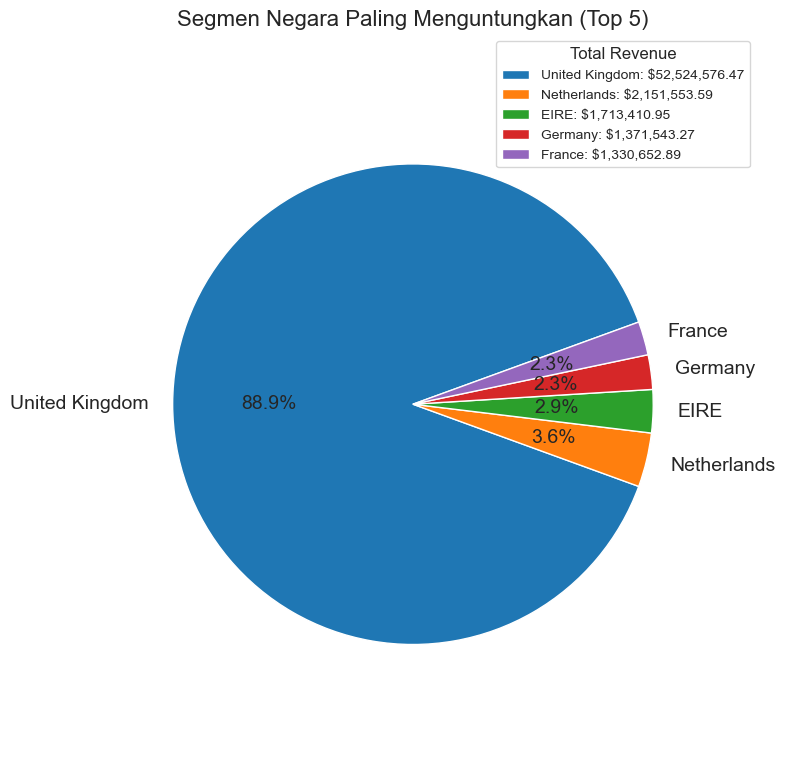

In [50]:
# Ambil Top 5 negara dengan revenue tertinggi
top_n = top_segments.head(5)

# Siapkan label legend dengan total revenue
legend_labels = [f"{country}: ${value:,.2f}" for country, value in zip(top_n.index, top_n.values)]

# Buat pie chart yang besar
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    top_n.values,
    labels=top_n.index,
    autopct='%1.1f%%',
    startangle=20,
    colors=plt.cm.tab10.colors,
    textprops={'fontsize': 14}
)

# Tambahkan legend kecil di pojok kanan atas
plt.legend(
    wedges,
    legend_labels,
    title="Total Revenue",
    loc="upper right",
    bbox_to_anchor=(1.15, 1),  # Posisi pojok kanan atas
    prop={'size': 10}           # Ukuran font legend
)

plt.title("Segmen Negara Paling Menguntungkan (Top 5)", fontsize=16)
plt.axis("equal")
plt.tight_layout()
plt.show()

#### Mengecek Customer United Kingdom

In [51]:
# Hitung jumlah pelanggan unik di United Kingdom
jumlah_pelanggan_UK = df_sales[df_sales["Country"] == "United Kingdom"]["CustomerNo"].nunique()
print("Jumlah Pelanggan Pada Negara United Kingdom :")
print(jumlah_pelanggan_UK)

# Group by CustomerNo, jumlahkan Revenue per customer di United Kingdom, dan urutkan dari terbesar ke terkecil
total_revenue_per_customer_UK = (
    df_sales[df_sales["Country"] == "United Kingdom"]
    .groupby("CustomerNo")["Revenue"]
    .sum()
    .reset_index()
    .sort_values(by="Revenue", ascending=False)
)

total_revenue_per_customer_UK.head(9)

Jumlah Pelanggan Pada Negara United Kingdom :
4305


,CustomerNo,Revenue
2904,16446.0,1002741.57
4168,18102.0,897137.36
3673,17450.0,891438.53
67,12346.0,840113.80
782,13694.0,646116.78
3718,17511.0,639006.19
1243,14298.0,636167.17
3087,16684.0,528587.34
2584,16029.0,435532.14


### Insight:
1.	Top 10 Most Profitable Customers:
- Grafik pertama menunjukkan 10 pelanggan paling menguntungkan berdasarkan total pendapatan (total revenue). Dari grafik tersebut, terlihat bahwa pelanggan dengan Customer No 14646 (Netherlands) memiliki kontribusi terbesar, dengan total pendapatan yang jauh lebih tinggi dibandingkan pelanggan lainnya, mencapai $2,112,282.03.
- Negara yang paling banyak berkontribusi adalah United Kingdom, dengan sebagian besar pelanggan datang dari sana, diikuti oleh EIRE dan Netherlands.

2. Segmen Negara Paling Menguntungkan (Top 5):
- Grafik kedua menunjukkan bahwa United Kingdom menyumbang 88.9% dari total pendapatan, yang menandakan bahwa pasar Inggris sangat dominan dalam kontribusi terhadap pendapatan.
- Negara lain yang berkontribusi meskipun lebih kecil adalah Netherlands (3.6%), EIRE (2.9%), Germany (2.3%), dan France (2.3%).

### Rekomendasi:
1.	Fokus pada Pelanggan dari United Kingdom:
- Mengingat United Kingdom adalah sumber utama pendapatan, disarankan untuk memperkuat strategi pemasaran di wilayah ini. Kampanye pemasaran khusus atau penawaran eksklusif dapat menarik lebih banyak pelanggan yang menguntungkan.
2.	Mengoptimalkan Pelanggan dari Negara Lain:
- Netherlands, EIRE, Germany, dan France meskipun memberikan kontribusi yang lebih kecil, tetap memiliki potensi. Disarankan untuk mengidentifikasi faktor yang menyebabkan rendahnya kontribusi negara-negara ini dan memperbaiki strategi pemasaran serta distribusi produk di wilayah tersebut.
3.	Strategi Diversifikasi:
- Mengingat dominasi United Kingdom, penting untuk menjaga diversifikasi pasar dengan tetap memperhatikan negara-negara lain yang meskipun kecil, namun dapat tumbuh dengan pendekatan yang tepat. Misalnya, meningkatkan customer loyalty program atau promosi khusus untuk pasar Eropa.
4.	Perhatikan Pelanggan Besar:
- Pelanggan dengan total pembelian besar, seperti Customer No 14646 (Netherlands), dapat menjadi target untuk program loyalitas jangka panjang atau menawarkan produk eksklusif agar mereka tetap menjadi pelanggan setia


# Berdasarkan temuan Anda, strategi apa yang dapat Anda rekomendasikan kepada bisnis untuk mendapatkan lebih banyak keuntungan?

Strategi yang Dapat Diterapkan untuk Meningkatkan Profit:

1. Fokus pada Kuartal Keempat (Q4):

- Mengingat tingginya performa yang tercatat pada kuartal keempat, sangat penting untuk memanfaatkan momentum tersebut dengan meningkatkan aktivitas promosi dan ketersediaan stok produk. Pada kuartal ini, permintaan cenderung meningkat, terutama menjelang akhir tahun, yang dapat dimanfaatkan dengan merancang kampanye pemasaran yang lebih agresif. Oleh karena itu, disarankan untuk mempersiapkan dan merencanakan promosi serta distribusi produk lebih awal untuk memastikan kesiapan dalam memenuhi permintaan yang tinggi selama periode tersebut.

2. Meningkatkan Stok untuk Produk Populer:

- Produk yang termasuk dalam kategori top 10, yang memiliki penjualan paling tinggi, harus dipastikan selalu tersedia di pasar. Produk-produk ini tidak hanya menjadi pilihan utama konsumen, tetapi juga dapat menjadi fokus utama dalam strategi periklanan. Dengan menjaga ketersediaan produk-produk populer tersebut, kita dapat meminimalisir kemungkinan kehabisan stok yang dapat berdampak pada penurunan penjualan. Selain itu, produk-produk ini harus terus dipromosikan untuk memastikan mereka tetap menarik perhatian konsumen dan mempertahankan dominasi pasar.

3. Segmentasi Pelanggan Berdasarkan Tingkat Profitabilitas:

- Salah satu pendekatan yang sangat efektif untuk meningkatkan profit adalah dengan melakukan segmentasi terhadap pelanggan, terutama pada pelanggan yang tergolong dalam kelompok top-tier atau pelanggan dengan kontribusi pembelian terbesar. Pelanggan-pelanggan ini berpotensi untuk memberikan profit yang berkelanjutan, sehingga penting untuk memberikan mereka insentif khusus, layanan prioritas, atau penawaran eksklusif yang membuat mereka merasa dihargai dan terus bertransaksi. Dengan memberikan perhatian khusus kepada segmen pelanggan ini, kita dapat membangun hubungan jangka panjang yang menguntungkan.

4. Dorong Pembelian Lebih Banyak per Transaksi:

- Untuk meningkatkan nilai transaksi rata-rata, strategi yang dapat diterapkan adalah dengan mendorong pelanggan untuk membeli lebih banyak produk dalam satu transaksi. Beberapa pendekatan yang dapat dipertimbangkan adalah dengan menawarkan bundling produk, yaitu menjual beberapa produk dalam satu paket dengan harga diskon yang menarik. Selain itu, memberikan diskon untuk pembelian dengan jumlah minimum atau mengimplementasikan strategi upselling pada saat checkout juga dapat meningkatkan nilai transaksi. Dengan menerapkan strategi-strategi ini, kita tidak hanya meningkatkan volume penjualan, tetapi juga meningkatkan kepuasan pelanggan yang merasa mendapatkan penawaran yang lebih baik.

